<a href="https://colab.research.google.com/github/IsaacSGray/L02twopOpt/blob/main/L02_2_Opt_f22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [L02: Implementing 2-Opt TSP](https://docs.google.com/document/d/1JA_CWBXPN6whvJAemnJLvtYJ3Pbk84dTUolWO_QqosA/edit?usp=sharing)
Written by Dr. Jan Pearce, Berea College

Complete the code by meeting all linked requirements and fixing all FIXMEs

## Your Name: Isaac Gray

**SUMMARY**: A brief summary description of the design and implementation, including how much your initial design plan evolved, the final result you achieved and the amount of time you spent as a programmer or programmers in accomplishing these results. This should be no more than two paragraphs.

The design was to do it iteratively. I started first with building my list of crossed edges. First it was a list of tuples. I later fixed this to a list of lists. I made sure to ignore the start node as an endpoint. I then built my calculate distance function, to calculate distance before and after swapping.

After that, I spent a lot more time on my two optswap, and my two opt. I had an embedded while and for loop which was breaking my function when I had 3 references to remove an edge- which kept my code running infinitely or crashing. I fixed this by removing the for loop and removing once in the while loop instead in an embedded function call in the while loop.. I achieved a graph which has no more crossed edges, however by the due date I did not get to reverse the direction of the nodes swapped, so the route of the graph is messed up.

I spent approximately 16 hours either researching, developing, experimenting, debugging. I absolutely hated using networkx as it is notoriously finicky and its documentation isn’t very clear- its a bit confusing to access and navigate through.


**PERSONNEL**: A description of who you worked with and on what sections.  It is expected that all collaboration is done as pair programming together. Also, note these collaborations in the code section itself.

I worked with John, and the TA a lot on the project. The TAhelped me build my crossed edges function, while I worked with John on the twoOpt function, which really helped getting the edges uncrossed and allowed me to progress to the very last part of the implementation, correcting the route.

**CHALLENGES**: Descriptions of the largest challenges you overcame and what made them challenging.

A big issue I had a lot of the time was an unending loop. I had this with an embedded for and while loop in which I overcame by nuking the for loop and implementing a clean deletion for each edge. I had to remembe the sheer complicated nature of my data structure organization, so I had to refactor that. I was trying to delete the same node in 3 places, wondering why I was looping forever.

This is due to the confusing and frustrating nature of networkx. A lot of my challenges is the networkx library. Its a huge confusing mess, some outdated documentation on methods that are abandoned and no longer work, so it really makes the rest of their documentation hard to really take at face value.


**INNOVATIONS**: Any innovations that were not specifically required by the assignment. These are not required, but should be highlighted if included.

I did not make any innovations that weren’t required by the document. If I had more time, I would fix the route so that it doesn’t get messed up.

**TESTING**: Describe how you tested this work.

The testing of my algorithm took many stages.

Dysfunctional loop:Endless looping, endless print statements, endless graphs, slowed google

Removed embedded for in while loop:
Infinite loop, less printing infinitely, more printing the end state of the graph infinitely, refusing to delete the last 2 crossed edges

Fixed loop entirely:
We no longer had infinite printing or graphs, we removed all crossed edges and rewired- no edge had no more than 2 edges. However the order of traversal was messed up.

**ERRORS**: A list in bulleted form of all known errors and deficiencies.

Route is incorrect, it was not reverted as we swapped- I am out of development time.

**COMMENTS**: A paragraph or so of your own comments on and reactions to the Lab.

I found this lab EXTREMELY frustrating. I hated it. Really it was a huge confusing mess. The TA getting sick isn’t his fault, but the professors office hours where we can get assistance from him wasn’t office hours for this course specifically, but office hours for all people whom need him. This makes getting the professor invested in where we are in the problem solving process difficult since he is juggling multiple meetings at once. Again- not his fault. It made finding time outside of my other TA hours, and a time where my TA wasn’t sick, and the professor wasn’t busy with others frustrating.

Does NOT help that the networkx notation has various abandoned methods that no longer work or dont work as intended. So it makes the documentation credibility doubtful a lot of the time so I spent way too much time on stackoverflow.


## Import Libraries

In [112]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import random
from urllib.request import urlopen

### Read data

In [117]:
def get_new_node_coords(numnodes, scale=1):
    """
    Create a new graph with numnodes nodes.
    Arguments:
        numnodes {int} -- number of nodes for your graph
    Keyword Arguments:
        scale {int} -- larger numbers squeeze nodes into a smaller space
    """
    nodeStr = f'{numnodes}\n'
    coords = []
    for i in range(numnodes):
        x, y = random.randint(1, numnodes//scale), random.randint(1, numnodes//scale)
        while (x, y) in coords:
            x, y = random.randint(1, numnodes//scale), random.randint(1, numnodes//scale)
        coords.append((x, y))
        nodeStr += f'{x} {y}\n'
    return nodeStr


# tspdata = urlopen("http://cs.berea.edu/courses/csc445/data/tsp-48.txt").read().decode('ASCII')
# tspdata = urlopen("http://cs.berea.edu/courses/csc445/data/tsp-small.txt").read().decode('ASCII')
tspdata = get_new_node_coords(20)
print(tspdata)

20
11 11
9 15
11 5
2 4
5 3
4 16
9 20
3 15
13 16
12 11
7 14
19 6
11 12
20 15
20 11
19 15
15 1
12 15
1 14
6 19



## TSP Class

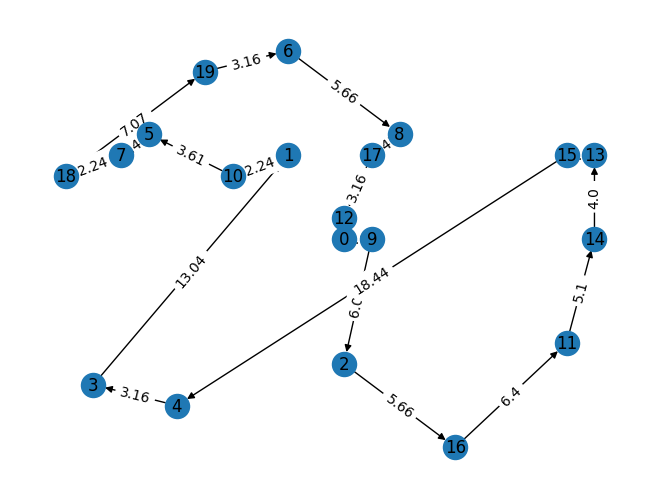

0
[[[9, 2], [15, 4]]]
[9, 2]
[15, 4]
[]


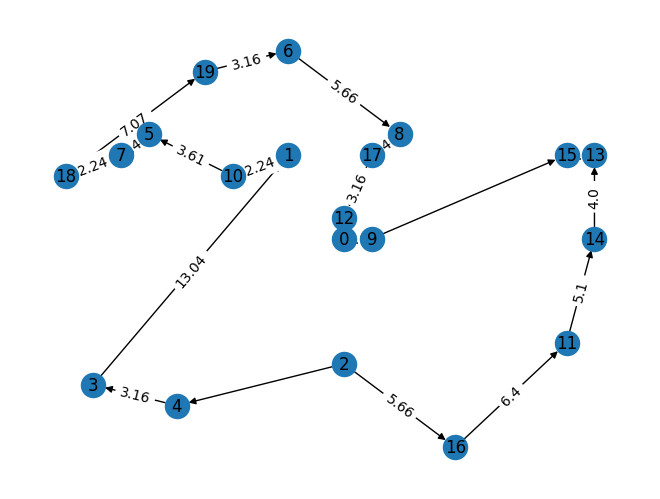

0
[1, 10, 5, 7, 18, 19, 6, 8, 17, 12, 0, 9, 2, 16, 11, 14, 13, 15, 4, 3, 1]


In [118]:
"""

Given certain input, it uses the 2-opt algorithm to plot a graph and output a file of the solution path
"""

class TSP:

    def __init__(self):
        """ TSP class containing data needed for networkx graph creation, file reading and file writing.
            Creates a graph for the traveling salesperon problem using the 2-opt algorithm
        """
        self.graph = nx.DiGraph()    # Graph object
        self.nodeData = []           # Stores node coordinates as list
        self.coords = {}             # Stores node coordinates as dict
        self.route = []              # Stores route as list of ints
        self.crossededges=[]         # stores the crossed edges if any

    def extractData(self, inputFile=""):
        """
        Iterate through the input file and append each coordinate into the node list.
        Keyword Arguments:
            inputFile {str} -- a string for the file name (default: {""})
        """
        WTSPC = ['\n', '\r', '\t', ' ']
        inputData = inputFile.split()
        cleanData = [int(i) for i in inputData if i not in WTSPC]

        self.dimension = cleanData[0]

        for i in range(1, len(cleanData), 2):
            nodeX = cleanData[i]
            nodeY = cleanData[i + 1]
            self.nodeData.append([nodeX, nodeY])

    def setUpCoords(self):
        """ Puts the coordinates for each node into a dictionary as a tuple with the node as the key """
        for i in range(len(self.nodeData)):
            self.coords[i] = self.nodeData[i]

    def calculateDistance(self, a, b):
        """calculates & returns the distance between points a and b
        Arguments:
            a {[tuple]} -- tuple of numbers for the x and y coordinate of a node
            b {[tuple]} -- tuple of numbers for the x and y coordinate of a node
        Returns:
            [float] -- the distance between the two points using the distance formula
        """
        x1 = float(a[0])
        y1 = float(a[1])
        x2 = float(b[0])
        y2 = float(b[1])
        xSquared = math.pow(x2 - x1, 2)
        ySquared = math.pow(y2 - y1, 2)

        # Round off for clarity when displaying edges
        c = round(math.sqrt(xSquared + ySquared), 2)
        return c

    def getGreedyRoute(self, start):
        """Builds a route using the Greedy algorithm
           Stores route in self.route
        Arguments:
            start {int} -- the node to start at, not a list index
        """
        self.route = [start]
        nVisited = [i for i in self.graph.nodes() if i != start]
        current = start
        while nVisited:
            distances = {i: self.calculateDistance(self.coords[current], self.coords[i]) for i in nVisited}
            minDist = 1000000000000
            closestNode = -1
            for node in distances:
                if distances[node] < minDist:
                    minDist = distances[node]
                    closestNode = node
            self.route.append(closestNode)
            nVisited.remove(closestNode)
            current = closestNode
        self.route.append(start)

    def getDirection(self, a, b, c):
        """Helper method for self.edgesCrossing
        Arguments:
            a {tuple (int, int)} -- The first endpoint of the first line
            b {tuple (int, int)} -- The second endpoint of the first line
            c {tuple (int, int)} -- An endpoint of the second line
        """
        ax, ay = self.coords[a][0], self.coords[a][1]
        bx, by = self.coords[b][0], self.coords[b][1]
        cx, cy = self.coords[c][0], self.coords[c][1]
        val = (by-ay)*(cx-bx)-(bx-ax)*(cy-by)
        if val < 0:
            return -1
        elif val > 0:
            return 1
        return 0

    def edgesCrossing(self, e1, e2):
        """Determines if edges e1 and e1 cross
        Arguments:
            e1 {tuple (int, int)} -- The first edge
            e2 {tuple (int, int)} -- The second edge
        Returns True if edges cross, False otherwise
        """
        a, b = e1[0], e1[1]
        c, d = e2[0], e2[1]

        if (a == c or a == d) or (b == c or b == d):
            # print(False)
            return False

        dir1 = self.getDirection(a, b, c);
        dir2 = self.getDirection(a, b, d);
        dir3 = self.getDirection(c, d, a);
        dir4 = self.getDirection(c, d, b);

        if dir1 != dir2 and dir3 != dir4:
          # print(True)
          return True
        # print(False)
        return False

    def getCrossingEdges(self, start):
        """Creates a list of all pairs of edges that cross
        Arguments:
            start {int} -- The starting node
        Returns list of edge pairs [ (e1, e2), (e3, e4), ... ]
          where e1 = (int, int), e2 = (int, int), etc...

          to be completed in L02
        """
        listofkeys=()
        listofkeys=self.graph.edges() #grab all edges
        # print(listofkeys)
        for u1,v1 in self.graph.edges: #iterate over edge node pair
          for u2,v2 in self.graph.edges: #iterate over the edge edges node pair
            if u1!=u2 & v1!=v2 : #make sure we are not iterating over the same edge
              edge=[u1,v1]
              edge2=[u2,v2]
              # print(edge)
              # print(edge2)
              if self.edgesCrossing(edge,edge2): #call edgescrossing with each edge
                if([edge,edge2] not in self.crossededges and [edge2,edge] not in self.crossededges): #make sure we do not iterate over the same edge in the reverse order
                  if(int(edge[1])!=start and int(edge2[1])!=start): #make sure our end point in either node edge is not start
                    self.crossededges.append([edge,edge2])
        # print(self.crossededges)



        #FIXME complete this function
        # Remember, you will want to ignore any edges with 'start' as an endpoint.

    def twoOpt(self, start):
        """ puts together the 2-opt algorithm. Gets the route order and adds the starting place to the end of the route
        Arguments:
            start -- the starting node for the two-Opt algorithm

            to be completed in L02
        """
        self.getCrossingEdges(start) #call getcrossingedges with start
        print(self.crossededges)
        while len(self.crossededges)!=0: #as long as there are crossing edges..
          self.getCrossingEdges(start) #recalculate crossededges
          self.twoOptSwap(self.crossededges[0][0],self.crossededges[0][1]) #swap these crossed edges
          self.crossededges.remove(self.crossededges[0]) #delete these crossed edges
          print(self.crossededges) #print updated list
          self.showGraph() #show new graph

          #REORDER THE NODES




        #FIXME complete this function

    def twoOptSwap(self, e1, e2):
        """ performs a single swap on a pair of edges, and handles all additional
               tasks involved in the swap
            e1 {tuple (int, int)} -- The first edge
            e2 {tuple (int, int)} -- The second edge

            to be completed in L02
        """
        e1local=[] #unpack the list
        e2local=[] #unpack the list
        e1local=e1
        e2local=e2

        print(e1local) #print this edges nodes
        print(e2local) #print this edges nodes
        u1,v1=e1
        u2,v2=e2
        if self.graph.has_edge(u1,v1): #check if these crossing edges are on the graph
          self.graph.remove_edge(u1,v1)  #remove them
          # self.crossededges.remove(self.crossededges[0][0])
        if self.graph.has_edge(u2,v2): #check if these crossing edges are on the graph
          self.graph.remove_edge(u2,v2) #remove them
          # self.crossededges.remove(self.crossededges[0][1])
        self.graph.add_edge(u1,u2) #connect a from (a,b) and c from (c,d)
        self.graph.add_edge(v1,v2)  #connect b from (a,b) and d from (c,d)



            #take two edges.
            #Check their neighbors for all edges connecting some nodes shared between each edge,
            #example (a,b) and (c,d), check for all edges that connect b and c
            #reverse all of them
            #remove edge (a,b) and (c,d)
            #add (a,c) and (b,d)
            #if no shared endpoint exist
            #we navigate from A to,C the other origin of the other path, add the edge (u1,u2)
            #everything in the middle of v1,u2 we want to reverse their direction
            #navigate from v1 to v2 and add the edge (v1,v2)


        #FIXME complete this function

    def calculateTotalDistance(self):
        """ calculates the total distance of the current route

        Return calculated distance

            to be completed in L02
        """
        pathweight=0
        lengthofpath=self.graph.size(weight="weight")
        return pathweight

        #FIXME complete this function

    def addNodes(self):
        """ adds nodes to the networkx graph
        """

        for node in self.coords:
            self.graph.add_node(node, pos=self.coords[node])

    def addEdges(self):
        """Adds graphs to the networkx graph
        """

        x = 0
        while x < len(self.route)-1:
            self.graph.add_edge(self.route[x], self.route[x+1],
                                weight=self.calculateDistance(self.coords[self.route[x]], self.coords[self.route[x+1]]))
            x += 1

    def showGraph(self):
        """Uses the imported libraries to display the graph
        """
        # get labels and coordinates for the graph
        coords = nx.get_node_attributes(self.graph, 'pos')
        labels = nx.get_edge_attributes(self.graph, 'weight')
        # draw nodes in their coordinates
        nx.draw(self.graph, coords)
        nx.draw_networkx_labels(self.graph, coords)
        # draw edges with their weights
        nx.draw_networkx_edge_labels(self.graph, coords, edge_labels=labels)
        plt.show()


def main():
    tsp = TSP()

    tsp.extractData(tspdata)
    tsp.setUpCoords()
    tsp.addNodes()
    tsp.getGreedyRoute(1) # feel free to use your solution from L01
    tsp.addEdges()
    tsp.showGraph()
    print(tsp.calculateTotalDistance())
    tsp.twoOpt(1)
    print(tsp.calculateTotalDistance())
    print(tsp.route)

main()

## Integrity statement
Please briefly describe all references you used, all help you received, and all help you gave to others in completing this assignment. Be sure to say that you got no help if you got none.